In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from scipy.stats import ttest_ind
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import re

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

%matplotlib inline
import warnings
# warnings.filterwarnings('ignore')

In [24]:
# Loading the dataset
df = pd.read_csv('../data/clean/df_0.csv', sep=',')

In [25]:
df

,id,text,target,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative
...,...,...,...,...
41637,9043,Not sure what happened but now I have to hit t...,1,neutral
41638,6160,"Pretty good app, lets you organize tasks by ca...",2,positive
41639,5655,This app is a piece of sh**. It won't sync my ...,0,negative
41640,11834,": Very interested. However, low carbs for the ...",2,positive


# Data Clean and Preprocessing 

**Clean the text**

In [26]:
# Preprocess the dataset: removing URLs, mentions and hashtags im 'text' column and convert to lowercase

# Define a function to clean the text
def clean_text(text):
    # Remove URLs, mentions, hashtags, and punctuation
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()  # Convert to lowercase

# Apply the text cleaning function
df['cleaned_text'] = df['text'].apply(clean_text)

# Inspect the cleaned text column
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"Cooking microwave pizzas, yummy",cooking microwave pizzas yummy
1,Any plans of allowing sub tasks to show up in ...,any plans of allowing sub tasks to show up in ...
2,"I love the humor, I just reworded it. Like sa...",i love the humor i just reworded it like sayi...
3,naw idk what ur talkin about,naw idk what ur talkin about
4,That sucks to hear. I hate days like that,that sucks to hear i hate days like that


<br>
<br>

**Tokenization and Lemmatization with spaCy**
 
 This step will break the text into individual words (tokens) and convert each word to its base form (lemma).This step should happen before fitting the TF-IDF vectorizer, so the vectorizer can work on the final, processed text.

In [27]:
# Load spaCy's small English model
nlp = spacy.load('en_core_web_sm')

# Function to tokenize and lemmatize text and also removes stopwords
def tokenize_and_lemmatize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop]  # Lemmatize and remove stopwords

# Apply the tokenization and lemmatization function
df['tokens'] = df['cleaned_text'].apply(tokenize_and_lemmatize)

# Inspect the tokenized and lemmatized text
print(df[['cleaned_text', 'tokens']].head())

                                        cleaned_text  \
0                     cooking microwave pizzas yummy   
1  any plans of allowing sub tasks to show up in ...   
2   i love the humor i just reworded it like sayi...   
3                       naw idk what ur talkin about   
4           that sucks to hear i hate days like that   

                                              tokens  
0                    [cook, microwave, pizza, yummy]  
1                   [plan, allow, sub, task, widget]  
2  [ , love, humor, reword, like, say, group, the...  
3                          [ , naw, idk, ur, talkin]  
4                   [ , suck, hear, hate, day, like]  


In [28]:
df

,id,text,target,sentiment,cleaned_text,tokens
0,9536,"Cooking microwave pizzas, yummy",2,positive,cooking microwave pizzas yummy,"[cook, microwave, pizza, yummy]"
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral,any plans of allowing sub tasks to show up in ...,"[plan, allow, sub, task, widget]"
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive,i love the humor i just reworded it like sayi...,"[ , love, humor, reword, like, say, group, the..."
3,14182,naw idk what ur talkin about,1,neutral,naw idk what ur talkin about,"[ , naw, idk, ur, talkin]"
4,17840,That sucks to hear. I hate days like that,0,negative,that sucks to hear i hate days like that,"[ , suck, hear, hate, day, like]"
...,...,...,...,...,...,...
41637,9043,Not sure what happened but now I have to hit t...,1,neutral,not sure what happened but now i have to hit t...,"[sure, happen, hit, sync, button, time, calend..."
41638,6160,"Pretty good app, lets you organize tasks by ca...",2,positive,pretty good app lets you organize tasks by cat...,"[pretty, good, app, let, organize, task, categ..."
41639,5655,This app is a piece of sh**. It won't sync my ...,0,negative,this app is a piece of sh it wont sync my old ...,"[app, piece, sh, will, not, sync, old, wunderl..."
41640,11834,": Very interested. However, low carbs for the ...",2,positive,very interested however low carbs for the nex...,"[ , interested, low, carb, month, mean, beer]"


<br>
<br>

**Split the Data into Training and Testing Sets**

Before we can fit the TF-IDF vectorizer and train the model, we need to split the dataset into training and testing sets. This allows us to evaluate the model’s performance on unseen data.

Split the dataset into a training set and a testing set.
- Training set: used to fit the TF-IDF vectorizer and train the machine learning model.
- Testing set: used to evaluate the model's performance.

In [11]:
# Split the data
X = df['cleaned_text']  # Features (text)
y = df['target']  # Target (sentiment label)

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the sizes of the training and testing sets
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 29203
Testing set size: 7301


<br>
<br>

# Feature Extraction
 
**Fit the TF-IDF Vectorizer**

Use **TF-IDF** (Term Frequency-Inverse Document Frequency) to convert the text into a numerical format, and then use a model like Logistic Regression or Naive Bayes to classify the sentiment.

In [12]:
# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000) # transforms text data into numerical vectors based on the TF-IDF scoring.
# limits the number of words in the vocabulary to the top 5000 most important terms (based on the term frequency and inverse document frequency).

# Fit the vectorizer on the training data (lemmatized text)
tfidf.fit(X_train) # The vectorizer goes through the training data (X_train) and learns the vocabulary and IDF weights.
# It scans the text and builds a vocabulary of words that it will use to create TF-IDF vectors.
# It calculates the Term Frequency (TF): How often each word appears in a document.
# It calculates the Inverse Document Frequency (IDF): How important a word is, based on how rare it is across the entire dataset.

# After fitting, the vectorizer knows:
# What the important words are based on their frequency across documents.
# How to assign importance to words by calculating the IDF scores.


# Save the vectorizer for future use
with open('../vectorizers/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# pickle.dump(tfidf, f) saves the fitted vectorizer into a file (tfidf_vectorizer.pkl) using the Python library pickle.
# The vectorizer has already learned the vocabulary and the TF-IDF weights from the training data. Saving it ensures that we can reuse the vectorizer later 
# in our application without having to refit it every time.

<br>
<br>

**Vectorize the Text Using TF-IDF**

In [13]:
# Transform the training and testing data
# Now that the vectorizer is fitted, it can convert the text data into a matrix of TF-IDF scores.

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Shape of training data: {X_train_tfidf.shape}")
# The transform() function takes the cleaned and lemmatized text and converts it into a sparse matrix of TF-IDF features.
# The resulting TF-IDF vectors are numerical representations of the original text that will be used to train and test the machine learning model.

Shape of training data: (29203, 5000)


In [14]:
display(X_train_tfidf)

<29203x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 400775 stored elements in Compressed Sparse Row format>

checking an example:

In [16]:
original_text = X_train[0]  # Get the first example of the original text

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Convert the first row of the transformed training data to an array and view the TF-IDF scores
first_example = X_train_tfidf[0]  # Get the first sample from the training data
first_example_dense = first_example.toarray()  # Convert sparse matrix to a dense array

# Create a dictionary of words and their corresponding TF-IDF scores
word_tfidf = {feature_names[i]: first_example_dense[0, i] for i in first_example.nonzero()[1]}

# Print the original text
print("Original Text:")
print(original_text)

# Print the example TF-IDF scores for the first document
print("\nTF-IDF scores for the first document:")
for word, score in word_tfidf.items():
    print(f"{word}: {score}")

Original Text:
is cursing abs wardrobe handles one drew blood

TF-IDF scores for the first document:
yup: 1.0


<br>
<br>

# Modeling: Logistic Regression

Code to train the Model:
- Train the Logistic Regression Model using the training TF-IDF vectors (*X_train_tfidf*) and the labels (*y_train*).
- Evaluate the model on the testing set (*X_test_tfidf*) to check its accuracy.

In [17]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the TF-IDF vectors (training data)
model.fit(X_train_tfidf, y_train)

# Save the trained model for future use
with open('../models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)

<br>
<br>

**Predict on the test set**

In [18]:
# Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Print some predictions and actual labels to check
print(f"Predictions: {y_pred[:10]}")
print(f"Actual labels: {y_test[:10].values}")

Predictions: [2 1 2 0 2 1 0 2 2 1]
Actual labels: [2 2 2 1 2 2 0 2 0 1]


<br>
<br>

Export **y_test** and **y_pred**

In [19]:
import pickle

# Save y_test
with open('../data/clean/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Save y_pred
with open('../data/clean/y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

<br>
<br>

**Evaluate the Model Performance**

In [20]:
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.674291192987262

In [21]:
# Evaluate the model
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.69      0.69      0.69      2457
     neutral       0.56      0.60      0.58      2381
    positive       0.78      0.73      0.76      2463

    accuracy                           0.67      7301
   macro avg       0.68      0.67      0.68      7301
weighted avg       0.68      0.67      0.68      7301



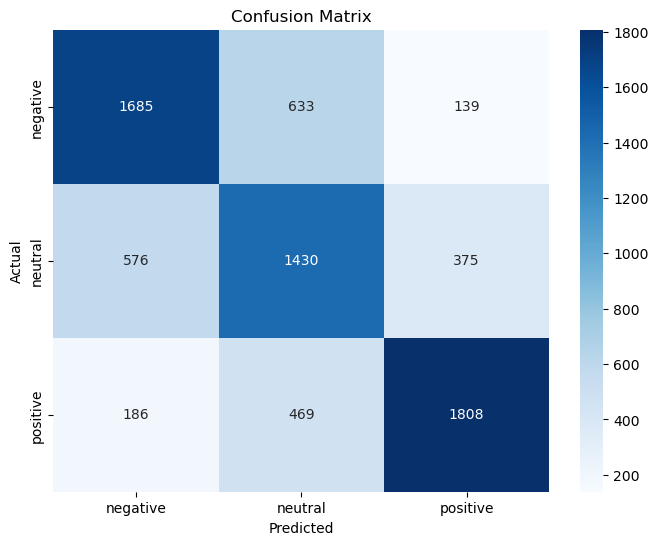

In [22]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

<br>
<br>

# Modeling: Naive Bayes

In [30]:
# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Train the model on the training data
nb_model.fit(X_train_tfidf, y_train)

# Save the trained model for future use
with open('../models/naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)


<br>
<br>

**Predict on the test set**

In [31]:
# Make predictions on the test data
y_pred_nb = nb_model.predict(X_test_tfidf)

# Print some predictions and actual labels to check
print(f"Predictions: {y_pred_nb[:10]}")
print(f"Actual labels: {y_test[:10].values}")


Predictions: [2 1 2 1 2 1 0 2 2 1]
Actual labels: [2 2 2 1 2 2 0 2 0 1]


<br>
<br>

**Evaluate the Model Performance**

Naive Bayes Accuracy: 0.6440
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2457
           1       0.53      0.56      0.54      2381
           2       0.73      0.70      0.72      2463

    accuracy                           0.64      7301
   macro avg       0.65      0.64      0.64      7301
weighted avg       0.65      0.64      0.65      7301



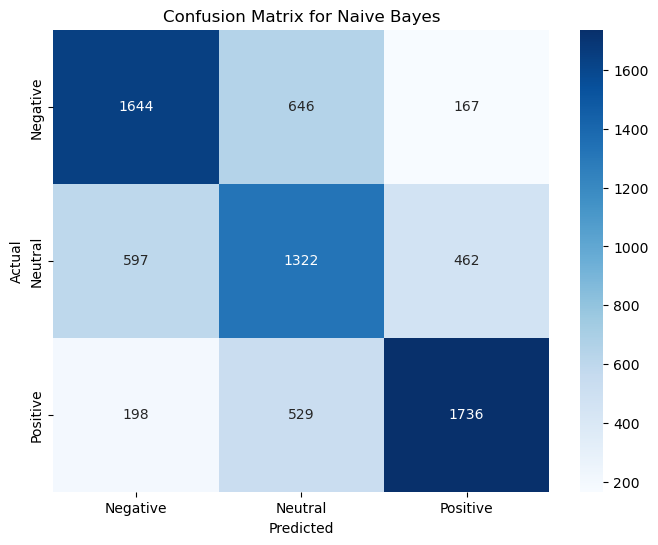

In [32]:
# Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()
